# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Analysing Datasets

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [5]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

### EDA

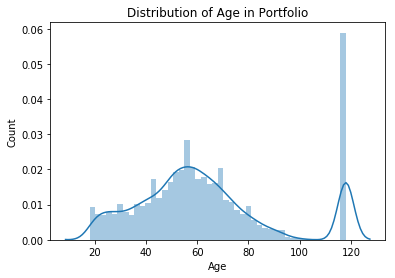

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(profile['age'],hist=True)
plt.title("Distribution of Age in Portfolio")
plt.xlabel("Age")
plt.ylabel("Count");

Age 118 is outlier with high count

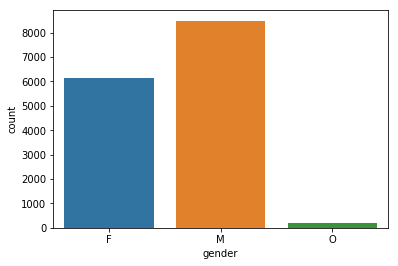

In [14]:
sns.countplot(x='gender',data=profile)

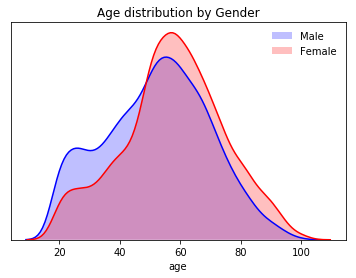

In [15]:
sns.distplot(profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False)

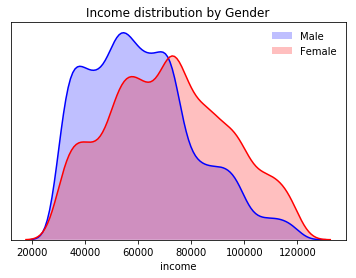

In [16]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False)

### Data Cleaning and Transforming

In [17]:
from datetime import date
import datetime
def clean_profile(profile):
    
    '''
    Function to clean profile dataframe.
    
    INPUT - Profile dataframe
    
    OUTPUT - Return cleaned version of profile dataframe
    
    '''
    
    #Convert became_member_on to datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format = '%Y%m%d')
    
    #Convert users with age 118 to np.nan
    profile['age'] = profile['age'].apply(lambda x: np.nan if x ==118 else x)
    
    #Create dummy columns for gender
    
    genders = pd.get_dummies(profile['gender'],prefix = "gender", prefix_sep = "-")
    
    profile = pd.concat([profile,genders],axis=1)
    
    #Change id column name to offer id
    
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    #Extract the number of days a user has been a member of the rewards app.
    today = pd.to_datetime(datetime.date.today().strftime('%Y%m%d'))
    
    
    profile['became_member_on'] = (today - profile['became_member_on']) / np.timedelta64(1,'D')
    
    
    
    return profile
    



In [18]:

profile = clean_profile(profile)
profile.head()

,age,became_member_on,gender,customer_id,income,gender-F,gender-M,gender-O
0,NaN,2023.0,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0
1,55.0,1870.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,NaN,1508.0,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0
3,75.0,1937.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,NaN,1850.0,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0


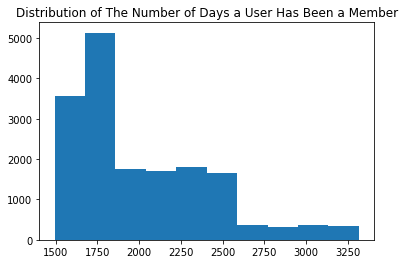

In [19]:
plt.hist(profile['became_member_on']);
plt.title('Distribution of The Number of Days a User Has Been a Member');

In [20]:
#Print mean and median for income
profile['income'].mean(), profile['income'].median()

(65404.991568296799, 64000.0)

In [21]:
def clean_portfolio(portfolio):
    
    '''
    Function to clean the portoflio dataset. Encode the categorical variables.
    
    Input - Portfolio dataframe
    
    Output - Portfolio dataframe with categorical variables handled
    '''
    
    #Apply one hot encodings to channels column
    
    #Email
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    #Mobile
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    #Social
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    #Web
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    #Create dummy columns for offer_type
    offer_types = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='-')
    
    portfolio = pd.concat([portfolio.drop(['offer_type','channels'],axis=1),offer_types],axis=1)
      
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio
portfolio = clean_portfolio(portfolio)

In [22]:
portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [23]:
def clean_transcript(transcript):
    
    #Extract offer_id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    
    #create two seperate columns for reward and amount
    
    for i in ['reward','amount']:
        transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)
    
    transcript.drop('value',axis=1,inplace=True)
    
    transcript.rename(columns={'person':'customer_id'},inplace=True)
    
    #Convert transcript time from hours to days
    transcript['time'] = transcript['time'] / 24
    
    return transcript
transcript = clean_transcript(transcript)

In [24]:
transcript.head()

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [25]:
#Explore transcript for one person

transcript[transcript['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,None,NaN,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,None,NaN,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,9.25,None,NaN,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.00,None,NaN,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,15.75,None,NaN,23.93


In [27]:
def transform_transcript(transcript):
    '''
    Function to transform transcript dataframe to return a dataframe where it shows each successful and unsuccesful offer.
    
    Input - Transcript dataframe 
    
    Output - transformed transcript dataframe
     
    '''
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    offer_customer.fillna(0.0, inplace = True)
    
    #Need to determine which offers where successful - where offer completed and offer viewed  are greater than 1.
    
    #We can multiply the two columns together and replace any values > 0 with 1.
    
    #This is an important step as some offers are completed but have not been viewed - meaning the offer did not cause the 
    #transaction.
    offer_customer['successful offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    
    offer_customer['successful offer'] = offer_customer['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_customer.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)                                                
                
    return offer_customer

transcript = transform_transcript(transcript)
                    

In [28]:
def merge_dataframes(profile,portfolio,transcript):
    
    '''
    Function to merge all the dataframes together.
    
    Input - profile, portfolio and transcript dataframes
    
    Output - single dataframe
    
    '''
    
    overall = transcript.merge(portfolio,how='left',on='offer_id')
    
    overall = overall.merge(profile,how='left',on='customer_id')
    
    
    return overall


overall_df = merge_dataframes(profile,portfolio,transcript)

overall_df.head()

,customer_id,offer_id,successful offer,difficulty,duration,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational,age,became_member_on,gender,income,gender-F,gender-M,gender-O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,10,7,2,1,1,0,1,0,1,0,33.0,1955.0,M,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,4,0,1,1,0,1,0,0,1,33.0,1955.0,M,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,0,1,1,1,0,0,0,1,33.0,1955.0,M,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,1,0,0,33.0,1955.0,M,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,10,10,2,1,1,1,1,0,1,0,33.0,1955.0,M,72000.0,0,1,0


We now have a single dataframe which includes information about the offer and information about the customer for every combination of offers and customers.

We also determined whether an offer was successful - which was when an offer was completed and viewed by the customer.

In [29]:
def change_offer_id(overall_df):
    
    '''
    Funtion to change the offer ids into a more readable form e.g offer 1, offer 2.
    
    Input - overall_df which is the combined dataframe from all 3 datasets.
    
    Output - overall_df with altered offer ids.
    
    '''
    
    unique_ids = list(overall_df['offer_id'].unique())
    
    for i in range(len(unique_ids)):
        
        overall_df['offer_id'] = overall_df['offer_id'].apply(lambda x: f'Offer {i+1}' if x == unique_ids[i] else x)
        
            
    return overall_df
            
overall_df = change_offer_id(overall_df)
overall_df.head()

,customer_id,offer_id,successful offer,difficulty,duration,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational,age,became_member_on,gender,income,gender-F,gender-M,gender-O
0,0009655768c64bdeb2e877511632db8f,Offer 1,0.0,10,7,2,1,1,0,1,0,1,0,33.0,1955.0,M,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,Offer 2,0.0,0,4,0,1,1,0,1,0,0,1,33.0,1955.0,M,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,Offer 3,0.0,0,3,0,1,1,1,0,0,0,1,33.0,1955.0,M,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,Offer 4,1.0,5,5,5,1,1,1,1,1,0,0,33.0,1955.0,M,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,Offer 5,1.0,10,10,2,1,1,1,1,0,1,0,33.0,1955.0,M,72000.0,0,1,0


In [30]:
overall_df['offer_id'].nunique()

10

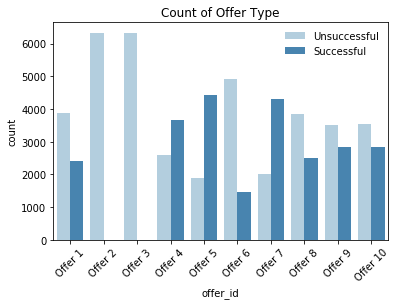

In [31]:
sns.countplot(x='offer_id',hue='successful offer',data=overall_df,palette='Blues');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('Count of Offer Type')

plt.xticks(rotation=45);

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


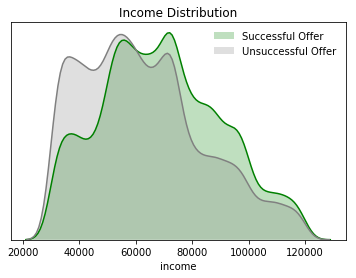

In [32]:
#Distribution of income whether offer was successful
sns.distplot(overall_df.loc[overall_df['successful offer'] == 1]['income'],hist=False,color='green',kde_kws={'shade':True})
sns.distplot(overall_df.loc[overall_df['successful offer'] == 0]['income'],hist=False,color='grey',kde_kws={'shade':True})
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Income Distribution');

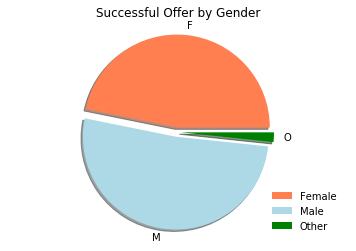

In [33]:
_ = overall_df.groupby(['gender'])['successful offer'].sum()

plt.pie(_, labels = _.index,shadow=True,explode = (0.05,0.05,0.05),colors=['coral','lightblue','green']);
plt.legend(['Female','Male','Other'],frameon=False)
plt.title("Successful Offer by Gender")

plt.gca().axis('Equal');

## Data Modeling
Now we have performed some exploratory analysis and initial cleaning on the datasets, we can now try a machine learning modelling approach to try and predict whether a customer offer combination will be successful.
#### Here we are now going to predict whether a user will complete an offer based on variables from the user and on the offer.



Using Machine Learning concepts, I will be using Logistic Regression, Random Forest Classifier to try and predict whether a customer receiving an offer will be successful.<br>
Also, to improvise the results GridSearch approach will be used.<br>
Evaluation Metrics for the model:<br> Precision, Recall, f1-score and Confusion matrix.<br>
1. Recall: The ability of a model to find all the relevant cases within a data set. Mathematically, we define recall as the number of true positives divided by the number of true positives plus the number of false negatives.<br>
2. Precision: The ability of a classification model to identify only the relevant data points. Mathematically, precision the number of true positives divided by the number of true positives plus the number of false positives.<br>
3. F1-score : the harmonic mean of Recall and Precision<br>
4. Confusion Matrix: Confusion matrix: shows the actual and predicted labels from a classification problem

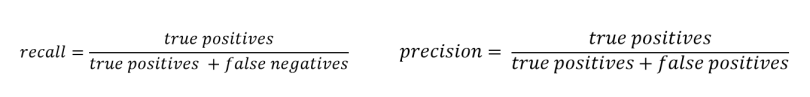

In [34]:
overall_df.isnull().sum()
#X.isnull().sum()

customer_id                    0
offer_id                       0
successful offer               0
difficulty                     0
duration                       0
reward                         0
email                          0
mobile                         0
social                         0
web                            0
offer_type-bogo                0
offer_type-discount            0
offer_type-informational       0
age                         8066
became_member_on               0
gender                      8066
income                      8066
gender-F                       0
gender-M                       0
gender-O                       0
dtype: int64

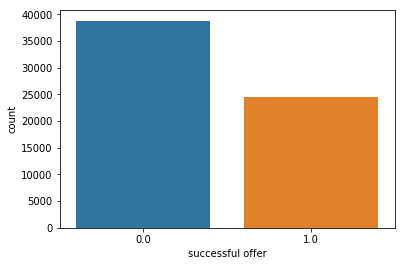

In [35]:
sns.countplot(overall_df['successful offer']);

As you can see there is a class inbalance which will effect the accuracy of the classifier. We will balance the classes by random over-sampling. So we will randomly samply datapoints from the successful offers with replacement untill we meet the number of datapoints we have for unsuccessful offers.

In [36]:
df_class1 = overall_df.loc[overall_df['successful offer']==1]
count_class0,count_class1 = overall_df['successful offer'].value_counts()
df_class1_over = df_class1.sample(count_class0,replace=True)

df_class_0 = overall_df.loc[overall_df['successful offer'] == 0]

over_df = pd.concat([df_class1_over,df_class_0],axis=0)

# over_df now has balanced classifying classes
over_df.drop('gender',axis=1,inplace=True)

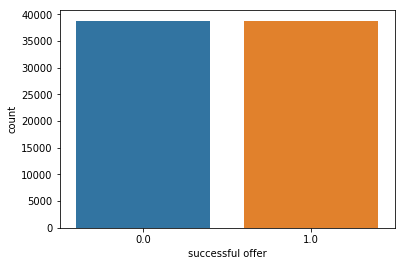

In [37]:
sns.countplot(over_df['successful offer']);

In [38]:
X = over_df.iloc[:,3:]
y = over_df.iloc[:,2]

X = pd.concat([X, over_df['offer_id']],axis=1)

def encode_offer_id(X):
    
    '''
    Fuction to encode offer id into dummy columns.
    
    Input - X dataframe with offer_id column present
    
    Output - X dataframe with encoded columns for offer id
    
    '''
    
    dummies = pd.get_dummies(X['offer_id'])
    
    new = pd.concat([X.drop('offer_id',axis=1), dummies],axis=1)
    
    
    return new

X = encode_offer_id(X)

X.columns

Index(['difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web',
       'offer_type-bogo', 'offer_type-discount', 'offer_type-informational',
       'age', 'became_member_on', 'income', 'gender-F', 'gender-M', 'gender-O',
       'Offer 1', 'Offer 10', 'Offer 2', 'Offer 3', 'Offer 4', 'Offer 5',
       'Offer 6', 'Offer 7', 'Offer 8', 'Offer 9'],
      dtype='object')

In [39]:
over_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77656 entries, 38440 to 63281
Data columns (total 19 columns):
customer_id                 77656 non-null object
offer_id                    77656 non-null object
successful offer            77656 non-null float64
difficulty                  77656 non-null int64
duration                    77656 non-null int64
reward                      77656 non-null int64
email                       77656 non-null int64
mobile                      77656 non-null int64
social                      77656 non-null int64
web                         77656 non-null int64
offer_type-bogo             77656 non-null uint8
offer_type-discount         77656 non-null uint8
offer_type-informational    77656 non-null uint8
age                         69080 non-null float64
became_member_on            77656 non-null float64
income                      69080 non-null float64
gender-F                    77656 non-null uint8
gender-M                    77656 non-null u

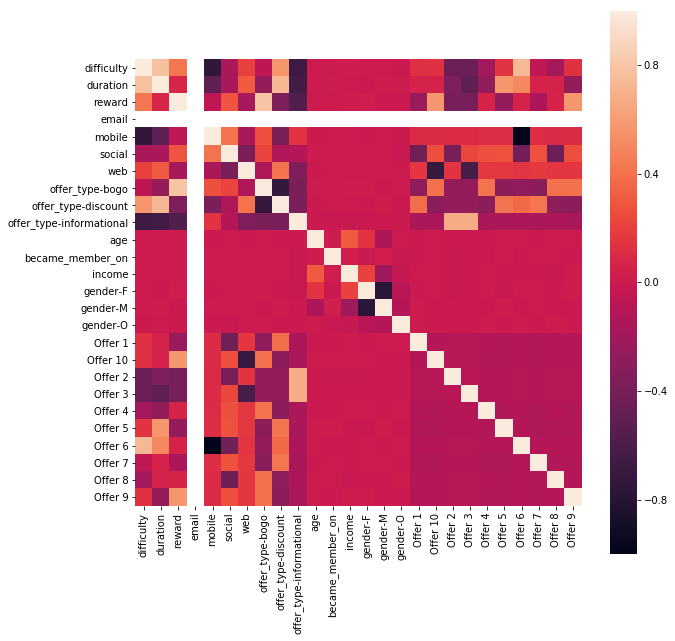

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),square=True);

In [41]:
#Impute missing values with median value for the column. I have chosen the median because both age and income have
#a right skew in their distributions.
for col in ['age','income']:
    over_df[col] = over_df[col].fillna(over_df[col].median())
    

As Logistic Regression assumes little or no multicolinearity i am going to drop the email feature as it appears to be strongly correlated with every feature.



In [42]:
X = over_df.iloc[:,3:]
y = over_df.iloc[:,2]

#### Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state = 42)

In [44]:
print(X_train.shape,X_test.shape)

(62124, 16) (15532, 16)


### Logistic Regression Approach

In [45]:
# scaling
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
model = LogisticRegression(solver='liblinear',random_state=42)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
model.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
log_pred = model.predict(X_test)


In [48]:
log_accuracy = accuracy_score(y_test,log_pred)

print("Logistic Regression Accuracy: %.2f" % accuracy_score(y_test, log_pred))

Logistic Regression Accuracy: 0.76


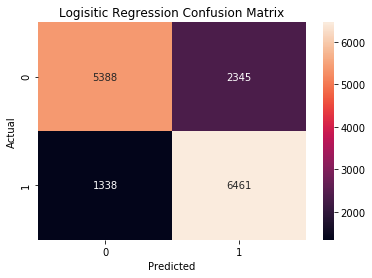

In [49]:
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='d')
plt.title('Logisitic Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [50]:
print(classification_report(y_test,log_pred))

             precision    recall  f1-score   support

        0.0       0.80      0.70      0.75      7733
        1.0       0.73      0.83      0.78      7799

avg / total       0.77      0.76      0.76     15532



### Random Forest Classifier Approach

In [51]:
#Instansiate Classifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)


#Train Classifier
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
y_pred = clf.predict(X_test)

print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test,y_pred)))

Model accuracy: 0.8499


In [53]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.89      0.80      0.84      7733
        1.0       0.82      0.90      0.86      7799

avg / total       0.85      0.85      0.85     15532



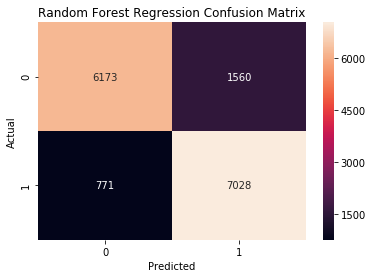

In [54]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.title('Random Forest Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

### Performing GridSearch for best parameters

In [55]:
parameters = {'n_estimators':[50,100],'criterion':['gini','entropy']}

grid_rand = GridSearchCV(RandomForestClassifier(), parameters, verbose=3, n_jobs=-1,cv=3)

In [56]:
grid_rand.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] criterion=gini, n_estimators=50 .................................
[CV] ........ criterion=gini, n_estimators=50, score=0.826782 -   2.7s
[CV] criterion=gini, n_estimators=50 .................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ........ criterion=gini, n_estimators=50, score=0.826202 -   2.7s
[CV] criterion=gini, n_estimators=50 .................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] ........ criterion=gini, n_estimators=50, score=0.822339 -   2.7s
[CV] criterion=gini, n_estimators=100 ................................
[CV] ....... criterion=gini, n_estimators=100, score=0.826492 -   5.5s
[CV] criterion=gini, n_estimators=100 ................................
[CV] ....... criterion=gini, n_estimators=100, score=0.826106 -   5.5s
[CV] criterion=gini, n_estimators=100 ................................
[CV] ....... criterion=gini, n_estimators=100, score=0.822532 -   5.5s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ..... criterion=entropy, n_estimators=50, score=0.826444 -   3.5s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ..... criterion=entropy, n_estimators=50, score=0.825575 -   3.4s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ..... criterion=entropy, n_estimators=50, score=0.821615 -   3.4s
[CV] criterion=entropy, n_estimators=100 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   56.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [57]:
grid_rand.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

In [ ]:
#Instansiate Classifier
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42)


#Train Classifier
clf.fit(X_train,y_train)


In [ ]:
y_pred1 = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred1))
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='d')
plt.title('Random Forest Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

Using Random Forest Classifier and GridSearch methods, we are able to improvise the False Negatives which are cases where the model predicted that offer was successful but actually it was not successful.Limiting these cases will help the robustness of the model.


#### Conclusion
Evaluation Metrics Performance:<br>Precision :82%,<br> Recall: 92%, <br>f1-score: 86% <br>
This model shows strong metric performance which ensures the "Starbucks Team" regarding the successful completion of the offer that has been assigned to that particular user.<br>Not only this,but also this model would help them to rule out poor performing offers and provide grounds to bring up something fresh. 